# Part A

# CNN ( Encoder ) + LSTM ( Decoder )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Installing the additinal Libraries required

In [ ]:
%pip install datasets
%pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for r

Importing all the required libraries

In [ ]:
import nltk
from collections import Counter
import pandas as pd
import os
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, BatchSampler
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.models as models
import torch.nn.functional as F
import datasets
import time
import math
import sys
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Checking the GPU environment

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pre Processing

Creating the vocabulary class for processing the captions

In [ ]:
class Vocabulary(object):
    def __init__(self,
                 vocab_threshold,
                 start_word="<start>",
                 end_word="<end>",
                 unk_word="<unk>",
                 data_folder='/content/drive/MyDrive/Data_IM/'):

        self.vocab_threshold = vocab_threshold
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.data_folder = data_folder
        self.build_vocab()

    def build_vocab(self):
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        counter = Counter()

        captions_df = pd.read_csv(os.path.join(self.data_folder, 'train.csv'))

        for i, caption in enumerate(captions_df['caption']):
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 1000 == 0:
                print(f"[{i}/{len(captions_df)}] captions tokenized...")

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

creating the dataset class

In [ ]:
class myDataset(Dataset):
    def __init__(self, transform, mode, batch_size, vocab_threshold,  start_word,
                 end_word, unk_word, data_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, start_word,
                                end_word, unk_word, data_folder)
        self.img_folder = os.path.join(data_folder, mode)

        # Loading captions and image paths
        self.captions_file = pd.read_csv(os.path.join(data_folder, f'{mode}.csv'))
        self.img_paths = self.captions_file['filename'].values
        self.captions = self.captions_file['caption'].values

        # Precomputing caption lengths for efficient sampling
        print('Obtaining caption lengths...')
        self.caption_lengths = [len(nltk.tokenize.word_tokenize(str(caption).lower())) for caption in tqdm(self.captions)]

    def __getitem__(self, index):
        # Loading  and transforming the image
        img_path = os.path.join(self.img_folder, self.img_paths[index])
        image = Image.open(img_path).convert('RGB')
        orig_image = np.array(image)
        if self.transform:
            image = self.transform(image)

        # Processing the caption
        caption = self.captions[index]
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption_tokens = []
        caption_tokens.append(self.vocab(self.vocab.start_word))
        caption_tokens.extend([self.vocab(token) for token in tokens])
        caption_tokens.append(self.vocab(self.vocab.end_word))
        caption_tokens = torch.tensor(caption_tokens, dtype=torch.long)
        if self.mode == 'train':
          return image, caption_tokens
        else:
          return orig_image,image,caption_tokens

    def get_train_indices(self):
        np.random.seed(42)
        counter = Counter(self.caption_lengths)
        lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
        top_10_lengths = [length for length, count in lengths[:10]]
        sel_length = np.random.choice(top_10_lengths)
        all_indices = [i for i, c_len in enumerate(self.caption_lengths) if c_len == sel_length]
        indices = list(np.random.choice(all_indices, size=min(len(all_indices), self.batch_size), replace=False))
        return indices

    def __len__(self):
        return len(self.img_paths)


Data loader for loading training data and testing data

In [ ]:
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               num_workers=0,
               data_folder='/content/drive/MyDrive/Data_IM/'):

    vocab = None
    dataset = myDataset(transform=transform,
                                   mode=mode,
                                   batch_size=batch_size,
                                   vocab_threshold=vocab_threshold,
                                   start_word=start_word,
                                   end_word=end_word,
                                   unk_word=unk_word,
                                   data_folder=data_folder,
                                 )

    if mode == 'train':
        indices = dataset.get_train_indices()
        initial_sampler = SubsetRandomSampler(indices)
        data_loader = DataLoader(dataset=dataset,
                                 num_workers=num_workers,
                                 batch_sampler=BatchSampler(sampler=initial_sampler,
                                                            batch_size=batch_size,
                                                            drop_last=False))

    else:

        data_loader = DataLoader(dataset=dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=num_workers)

    return data_loader

Transformation for image


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

Loading the training data

In [ ]:
vocab_threshold = 5
batch_size = 128
data_folder = '/content/drive/MyDrive/Data_IM'

# Train data loader
train_data = get_loader(transform=transform,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         data_folder=data_folder)

[0/5715] captions tokenized...
[1000/5715] captions tokenized...
[2000/5715] captions tokenized...
[3000/5715] captions tokenized...
[4000/5715] captions tokenized...
[5000/5715] captions tokenized...
Obtaining caption lengths...


100%|██████████| 5715/5715 [00:03<00:00, 1863.07it/s]


Total number of words in the training vocabulary

In [ ]:
print('Total number of tokens in vocabulary:', len(train_data.dataset.vocab))

Total number of tokens in vocabulary: 2553


The count of the different caption lengths

In [ ]:
from collections import Counter
counter = Counter(train_data.dataset.caption_lengths)
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
for value, count in lengths:
    print('Length: %2d -> count: %2d' % (value, count))

Length: 74 -> count: 170
Length: 72 -> count: 168
Length: 73 -> count: 151
Length: 71 -> count: 145
Length: 78 -> count: 145
Length: 75 -> count: 144
Length: 69 -> count: 143
Length: 70 -> count: 143
Length: 77 -> count: 131
Length: 76 -> count: 130
Length: 37 -> count: 108
Length: 68 -> count: 106
Length: 80 -> count: 103
Length: 36 -> count: 100
Length: 79 -> count: 99
Length: 67 -> count: 99
Length: 83 -> count: 95
Length: 82 -> count: 93
Length: 35 -> count: 90
Length: 39 -> count: 89
Length: 65 -> count: 88
Length: 66 -> count: 86
Length: 33 -> count: 86
Length: 32 -> count: 83
Length: 86 -> count: 82
Length: 38 -> count: 80
Length: 41 -> count: 79
Length: 81 -> count: 78
Length: 42 -> count: 77
Length: 64 -> count: 77
Length: 34 -> count: 77
Length: 40 -> count: 76
Length: 85 -> count: 72
Length: 30 -> count: 70
Length: 84 -> count: 67
Length: 43 -> count: 66
Length: 44 -> count: 65
Length: 31 -> count: 64
Length: 29 -> count: 62
Length: 47 -> count: 60
Length: 87 -> count: 59
Le

average caption length in the training data

In [ ]:
print('Average Caption Length:', sum(train_data.dataset.caption_lengths) / len(train_data.dataset.caption_lengths))

Average Caption Length: 67.07226596675416


Total number of unique values

In [ ]:
unique_values = set(train_data.dataset.caption_lengths)

num_unique_values = len(unique_values)

#  number of unique values
print("Number of unique lengths:", num_unique_values)

Number of unique lengths: 158


# Model Creating

Architecure of CNN and LSTM

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, drop_p=0.1):
        super(DecoderRNN, self).__init__()

        # Model attributes
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        # Embedding
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)

        self.lstm = nn.LSTM(self.embed_size,
                            self.hidden_size,
                            self.num_layers,
                            dropout=drop_p,
                            batch_first=True)

        self.dropout = nn.Dropout(drop_p)

        self.fc = nn.Linear(self.hidden_size, self.vocab_size)


    def forward(self, features, captions):
        captions = captions[:, :-1]
        embed = self.embedding(captions)
        features = features.view(features.size(0), 1, -1)
        inputs = torch.cat((features, embed), dim=1)
        lstm_out, hidden = self.lstm(inputs)
        out = lstm_out.reshape(lstm_out.size(0)*lstm_out.size(1), lstm_out.size(2))
        out = self.dropout(out)
        out = self.fc(out)
        out = out.view(lstm_out.size(0), lstm_out.size(1), -1)
        return out

    def sample(self, inputs, states=None, max_len=67):
        device = inputs.device
        outputs = []

        for i in range(max_len):
            with torch.no_grad():
                lstm_out, states = self.lstm(inputs, states)
                out = self.fc(lstm_out.squeeze(1))
                _, predicted = out.max(1)
                outputs.append(predicted.item())

                inputs = self.embedding(predicted)
                inputs = inputs.unsqueeze(1)
                inputs = inputs.to(device)

            # Assuming that end is at index 1
            if predicted.item() == 1:
                break

        return outputs

Initialising the model instances

In [ ]:
embed_size = 128
hidden_size = 256
num_epochs = 10
vocab_size = len(train_data.dataset.vocab)


# Model initialisation
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# loss function.
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# learnable parameters of the model.
params = list(encoder.embed.parameters()) + list(decoder.parameters())

#  optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas = (0.9, 0.999), eps = 1e-08)

# Setting the total number of training steps per epoch.
total_step = math.ceil(len(train_data.dataset.caption_lengths) / train_data.batch_sampler.batch_size)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Model Training

In [ ]:
for epoch in range(1, num_epochs+1):

        encoder.train()  # Setting the encoder to training mode
        decoder.train()  # Setting the decoder to training mode

        for i_step in range(1, total_step+1):

            indices = train_data.dataset.get_train_indices()
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            train_data.batch_sampler.sampler = new_sampler

            images, captions = next(iter(train_data))
            images = images.to(device)
            captions = captions.to(device)

            decoder.zero_grad()
            encoder.zero_grad()

            features = encoder(images)
            outputs = decoder(features, captions)

            # loss.
            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

            # Backward pass.
            loss.backward()

            # Updating the parameters in the optimizer.
            optimizer.step()
            # Getting training statistics.
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f' % (epoch, num_epochs, i_step, total_step, loss.item())


            # Printing training statistics.
            print( stats)




Epoch [1/10], Step [1/45], Loss: 7.8405
Epoch [1/10], Step [2/45], Loss: 7.7933
Epoch [1/10], Step [3/45], Loss: 7.7460
Epoch [1/10], Step [4/45], Loss: 7.6915
Epoch [1/10], Step [5/45], Loss: 7.6266
Epoch [1/10], Step [6/45], Loss: 7.5406
Epoch [1/10], Step [7/45], Loss: 7.4225
Epoch [1/10], Step [8/45], Loss: 7.2414
Epoch [1/10], Step [9/45], Loss: 6.9516
Epoch [1/10], Step [10/45], Loss: 6.5421
Epoch [1/10], Step [11/45], Loss: 6.1528
Epoch [1/10], Step [12/45], Loss: 5.8418
Epoch [1/10], Step [13/45], Loss: 5.5878
Epoch [1/10], Step [14/45], Loss: 5.3854
Epoch [1/10], Step [15/45], Loss: 5.2241
Epoch [1/10], Step [16/45], Loss: 5.1110
Epoch [1/10], Step [17/45], Loss: 5.0337
Epoch [1/10], Step [18/45], Loss: 4.9917
Epoch [1/10], Step [19/45], Loss: 4.9696
Epoch [1/10], Step [20/45], Loss: 4.9613
Epoch [1/10], Step [21/45], Loss: 4.9598
Epoch [1/10], Step [22/45], Loss: 4.9520
Epoch [1/10], Step [23/45], Loss: 4.9488
Epoch [1/10], Step [24/45], Loss: 4.9283
Epoch [1/10], Step [25/45

# Model Evaluation

Loading the testing data

In [ ]:
test_loader = get_loader(transform=transform,
                         mode='test',
                         batch_size=1,
                         vocab_threshold=vocab_threshold,
                         data_folder=data_folder)

[0/5715] captions tokenized...
[1000/5715] captions tokenized...
[2000/5715] captions tokenized...
[3000/5715] captions tokenized...
[4000/5715] captions tokenized...
[5000/5715] captions tokenized...
Obtaining caption lengths...


100%|██████████| 928/928 [00:00<00:00, 1845.07it/s]


Function for decoding the output token id's to words

In [ ]:
def clean_sentence(output):

    start = 0
    end = len(output)-1
    point = end
    for i in range(len(output)):
        if output[i] == 0:
            start = i+1
            continue
        if output[i] == 18:
            point = i
            continue
        if output[i] == 1:
            end = i
            break
    if point > end:
        point = end
    sentence = " ".join([train_data.dataset.vocab.idx2word[x] for x in output[start:point]])

    return sentence

Loading the Rouge_L Metric

In [ ]:
rouge = datasets.load_metric("rouge")

<ipython-input-20-735a92881502>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")


The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Getting the outputs from testing data

In [ ]:
# Initialising a list to store captions for all images
all_captions = []
all_ref = []
# Iterating over the test_loader
for orig_image, image, captions in test_loader:
    # Move image to CPU
    orig_image = orig_image.cpu()
    captions = captions[0].cpu().numpy().tolist()

    ref_str = clean_sentence(captions)
    all_ref.append(ref_str)

    # Move image to GPU
    image = image.to(device)


    # Obtaining the embedded image features
    features = encoder(image).unsqueeze(1)
    features = features.to(device)

    # Generating output captions
    output = decoder.sample(features)


    # Cleaning the output sentence
    caption = clean_sentence(output)

    # Storing the caption for this image
    all_captions.append(caption)


Computation of Rouge_L score

In [ ]:
#calculating rouge score
rouge_output = rouge.compute(predictions=all_captions, references=all_ref, rouge_types=["rougeL"])["rougeL"].mid
print("Rouge_L score:",rouge_output)

Rouge_L score: Score(precision=0.26140672377536245, recall=0.22094512801983834, fmeasure=0.2244434450044127)


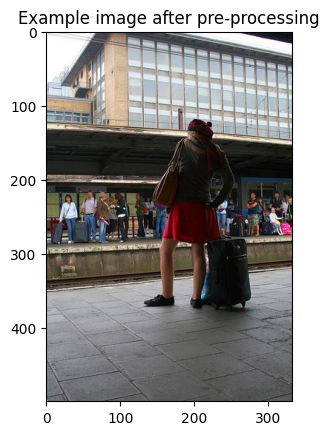

In [ ]:

orig_image,image, captions = next(iter(test_loader))
# Move to CPU since we're just displaying images
plt.imshow(np.squeeze(orig_image))
plt.title('Example image after pre-processing')
plt.show()

In [ ]:
image = image.to(device)
features = encoder(image).unsqueeze(1)
features = features.to(device)
output = decoder.sample(features)
print('example output vocab ids:', output)
print('example output tokens:', [train_data.dataset.vocab.idx2word[x] for x in output])

example output vocab ids: [0, 3, 186, 7, 124, 8, 3, 184, 185, 14, 21, 309, 7, 106, 3, 43, 387, 59, 3, 1970, 110, 14, 3, 1762, 1633, 1960, 10, 4, 442, 59, 7, 810, 8, 3, 4, 1423, 63, 14, 21, 148, 7, 95, 59, 4, 14, 42, 20, 213, 146, 84, 21, 148, 14, 21, 148, 7, 4, 10, 3, 4, 795, 14, 1]
example output tokens: ['<start>', 'a', 'woman', 'is', 'standing', 'on', 'a', 'sunny', 'day', '.', 'the', 'man', 'is', 'wearing', 'a', 'black', 'jacket', 'and', 'a', 'beanie', 'cap', '.', 'a', 'partially', 'bald', 'gentleman', 'with', 'white', 'shorts', 'and', 'is', 'carrying', 'on', 'a', 'white', 'marble', 'top', '.', 'the', 'sky', 'is', 'blue', 'and', 'white', '.', 'there', 'are', 'some', 'trees', 'behind', 'the', 'sky', '.', 'the', 'sky', 'is', 'white', 'with', 'a', 'white', 'roof', '.', '<end>']


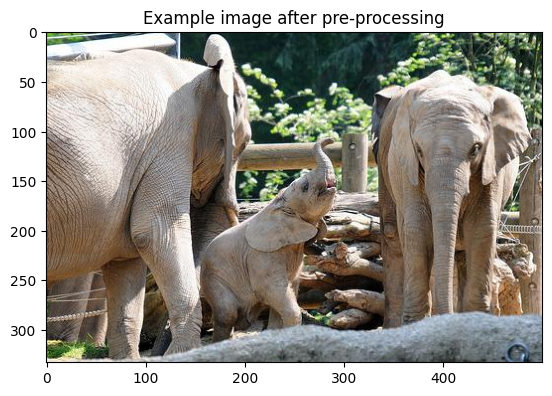

In [ ]:
orig_image,image, captions = next(iter(test_loader))
# Move to CPU since we're just displaying images
plt.imshow(np.squeeze(orig_image))
plt.title('Example image after pre-processing')
plt.show()

In [ ]:
image = image.to(device)
features = encoder(image).unsqueeze(1)
features = features.to(device)
output = decoder.sample(features)
print('example output vocab ids:', output)
print('example output tokens:', [train_data.dataset.vocab.idx2word[x] for x in output])

example output vocab ids: [0, 3, 186, 7, 124, 8, 3, 184, 185, 14, 21, 309, 7, 106, 3, 43, 387, 59, 3, 1970, 110, 14, 3, 1762, 1633, 1960, 10, 4, 442, 59, 7, 810, 8, 3, 4, 1423, 63, 14, 21, 148, 7, 95, 59, 4, 14, 42, 20, 213, 146, 84, 21, 148, 14, 21, 148, 7, 4, 10, 3, 4, 795, 14, 1]
example output tokens: ['<start>', 'a', 'woman', 'is', 'standing', 'on', 'a', 'sunny', 'day', '.', 'the', 'man', 'is', 'wearing', 'a', 'black', 'jacket', 'and', 'a', 'beanie', 'cap', '.', 'a', 'partially', 'bald', 'gentleman', 'with', 'white', 'shorts', 'and', 'is', 'carrying', 'on', 'a', 'white', 'marble', 'top', '.', 'the', 'sky', 'is', 'blue', 'and', 'white', '.', 'there', 'are', 'some', 'trees', 'behind', 'the', 'sky', '.', 'the', 'sky', 'is', 'white', 'with', 'a', 'white', 'roof', '.', '<end>']


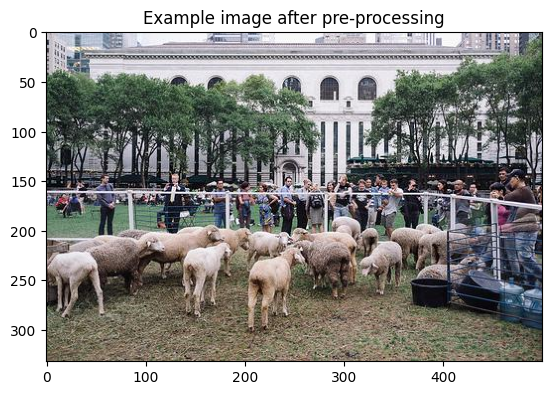

In [ ]:
orig_image,image, captions = next(iter(test_loader))
# Move to CPU since we're just displaying images
plt.imshow(np.squeeze(orig_image))
plt.title('Example image after pre-processing')
plt.show()

In [ ]:
image = image.to(device)
features = encoder(image).unsqueeze(1)
features = features.to(device)
output = decoder.sample(features)
print('example output vocab ids:', output)
print('example output tokens:', [train_data.dataset.vocab.idx2word[x] for x in output])

example output vocab ids: [0, 3, 186, 7, 124, 8, 3, 184, 185, 14, 21, 309, 7, 106, 3, 43, 387, 59, 3, 1970, 110, 14, 3, 1762, 1633, 1960, 10, 4, 442, 59, 7, 810, 8, 3, 4, 1423, 63, 14, 21, 148, 7, 95, 59, 4, 14, 42, 20, 213, 146, 84, 21, 148, 14, 21, 148, 7, 4, 10, 3, 4, 795, 14, 1]
example output tokens: ['<start>', 'a', 'woman', 'is', 'standing', 'on', 'a', 'sunny', 'day', '.', 'the', 'man', 'is', 'wearing', 'a', 'black', 'jacket', 'and', 'a', 'beanie', 'cap', '.', 'a', 'partially', 'bald', 'gentleman', 'with', 'white', 'shorts', 'and', 'is', 'carrying', 'on', 'a', 'white', 'marble', 'top', '.', 'the', 'sky', 'is', 'blue', 'and', 'white', '.', 'there', 'are', 'some', 'trees', 'behind', 'the', 'sky', '.', 'the', 'sky', 'is', 'white', 'with', 'a', 'white', 'roof', '.', '<end>']
